In [1]:
import pandas as pd
import numpy as np

In [2]:
# Menggabungkan data
data1="data/goemotions_1.csv"
data2="data/goemotions_2.csv"
data3="data/goemotions_3.csv"

df1=pd.read_csv(data1)
df2=pd.read_csv(data2)
df3=pd.read_csv(data3)
merged = [df1, df2, df3]

data = pd.concat(merged)

In [3]:
# Menampilkan 5 baris data pertama
data.shape

(211225, 37)

In [4]:
# Menampilkan statistik data
data.describe()

,created_utc,rater_id,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
count,2.112250e+05,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,...,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000
mean,1.547659e+09,37.619742,0.081103,0.043768,0.038272,0.064472,0.083418,0.028401,0.034840,0.045885,...,0.038779,0.008569,0.041259,0.006164,0.041591,0.006102,0.011954,0.031994,0.026105,0.261797
std,7.696842e+05,23.070528,0.272994,0.204580,0.191853,0.245592,0.276514,0.166116,0.183374,0.209236,...,0.193067,0.092172,0.198890,0.078269,0.199653,0.077880,0.108679,0.175985,0.159448,0.439614
min,1.546301e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.546993e+09,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.547664e+09,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.548320e+09,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.548979e+09,81.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Data Cleaning: mengecek nilai null pada data
data.isna().sum()

text                    0
id                      0
author                  0
subreddit               0
link_id                 0
parent_id               0
created_utc             0
rater_id                0
example_very_unclear    0
admiration              0
amusement               0
anger                   0
annoyance               0
approval                0
caring                  0
confusion               0
curiosity               0
desire                  0
disappointment          0
disapproval             0
disgust                 0
embarrassment           0
excitement              0
fear                    0
gratitude               0
grief                   0
joy                     0
love                    0
nervousness             0
optimism                0
pride                   0
realization             0
relief                  0
remorse                 0
sadness                 0
surprise                0
neutral                 0
dtype: int64

In [6]:
import re
import string
import json
!pip install emoji
import emoji
import numpy as np
import pandas as pd

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [8]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [9]:
data['text'] = data['text'].apply(text_preprocessing_pipeline)

In [10]:
# Menyimpan hasil data preprocessing kedalam file csv
data.to_csv('data/goemotions.csv', index = False)

In [11]:
data=pd.read_csv("data/goemotions.csv")
data

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,that game hurt,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,sexuality shouldn t be a grouping category it ...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,you do right if you do not care then fuck em,ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,man i love reddit,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,was nowhere near them he was by the falcon,eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211220,everyone likes,ee6pagw,Senshado,heroesofthestorm,t3_agjf24,t3_agjf24,1.547634e+09,16,False,0,...,1,0,0,0,0,0,0,0,0,0
211221,well when you ve imported about a gazillion of...,ef28nod,5inchloser,nottheonion,t3_ak26t3,t3_ak26t3,1.548553e+09,15,False,0,...,0,0,0,0,0,0,0,0,0,0
211222,that looks amazing,ee8hse1,springt1me,shittyfoodporn,t3_agrnqb,t3_agrnqb,1.547684e+09,70,False,1,...,0,0,0,0,0,0,0,0,0,0
211223,the fda has plenty to criticize but like here ...,edrhoxh,enamedata,medicine,t3_aejqzd,t1_edrgdtx,1.547169e+09,4,False,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
data = data.sample(frac =0.2)

In [15]:
from sklearn.model_selection import train_test_split
X = data['text'].values
X= X.astype(str)
y = data.iloc[:,9:].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [17]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
# !pip install --user keras
# !pip install --user tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import model_from_json
from keras.models import load_model

pd.set_option('display.max_colwidth', 200)

tokenizer = Tokenizer() #make a tokenizer
tokenizer.fit_on_texts(X_train) #fit on text


num_words=7000
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= num_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = num_words + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 20
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index)+1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix
    
embedding_dim = 300
embedding_matrix = create_embedding_matrix('data/glove.6B.300d.txt', tokenizer.word_index, embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
embedding_accuracy = nonzero_elements / vocab_size
print('embedding accuracy: ' + str(embedding_accuracy))

embedding accuracy: 0.977577834904313


<h3> Model Building</h3>

In [19]:
# create the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
    
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(28, activation='softmax'))
# Adam Optimiser
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           2100600   
_________________________________________________________________
bidirectional (Bidirectional (None, 512)               1140736   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
Total params: 3,310,612
Trainable params: 3,310,612
Non-trainable params: 0
_________________________________________________________________


In [20]:
result = model.fit(X_train, y_train, epochs=15, verbose=True, validation_data=(X_test, y_test), batch_size=100)

Epoch 1/15
296/296 [==============================] - 207s 672ms/step - loss: 0.1837 - accuracy: 0.2211 - val_loss: 0.1423 - val_accuracy: 0.3276
Epoch 2/15
296/296 [==============================] - 202s 683ms/step - loss: 0.1460 - accuracy: 0.3329 - val_loss: 0.1338 - val_accuracy: 0.3520
Epoch 3/15
296/296 [==============================] - 193s 653ms/step - loss: 0.1362 - accuracy: 0.3640 - val_loss: 0.1293 - val_accuracy: 0.3662
Epoch 4/15
296/296 [==============================] - 193s 653ms/step - loss: 0.1300 - accuracy: 0.3799 - val_loss: 0.1275 - val_accuracy: 0.3706
Epoch 5/15
296/296 [==============================] - 194s 657ms/step - loss: 0.1248 - accuracy: 0.3995 - val_loss: 0.1269 - val_accuracy: 0.3684
Epoch 6/15
296/296 [==============================] - 195s 657ms/step - loss: 0.1199 - accuracy: 0.4159 - val_loss: 0.1284 - val_accuracy: 0.3712
Epoch 7/15
296/296 [==============================] - 202s 684ms/step - loss: 0.1149 - accuracy: 0.4350 - val_loss: 0.1309 -

In [21]:
#from the above results number of epochs = 7
result = model.fit(X_train, y_train, epochs=7, verbose=False, validation_data=(X_test, y_test), batch_size=100)

In [22]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#making predictions
y_pred = model.predict(X_test)

thresholds=[0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=y_pred.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test, pred, average='micro')
    recall = recall_score(y_test, pred, average='micro')
    f1 = f1_score(y_test, pred, average='micro')
   
    print("Threshold: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(val, precision, recall, f1))

Threshold: 0.1000, Precision: 0.2788, Recall: 0.4052, F1-measure: 0.3303
Threshold: 0.2000, Precision: 0.3243, Recall: 0.3526, F1-measure: 0.3379
Threshold: 0.2500, Precision: 0.3390, Recall: 0.3332, F1-measure: 0.3361
Threshold: 0.3000, Precision: 0.3527, Recall: 0.3195, F1-measure: 0.3353
Threshold: 0.4000, Precision: 0.3702, Recall: 0.2909, F1-measure: 0.3258
Threshold: 0.5000, Precision: 0.3886, Recall: 0.2664, F1-measure: 0.3161
Threshold: 0.6000, Precision: 0.4076, Recall: 0.2454, F1-measure: 0.3064
Threshold: 0.7000, Precision: 0.4244, Recall: 0.2242, F1-measure: 0.2934
Threshold: 0.8000, Precision: 0.4449, Recall: 0.2020, F1-measure: 0.2778
Threshold: 0.9000, Precision: 0.4674, Recall: 0.1713, F1-measure: 0.2507


Emotion: admiration, Precision: 0.4245, Recall: 0.4641, F1-measure: 0.4434
Emotion: amusement, Precision: 0.4761, Recall: 0.5494, F1-measure: 0.5102
Emotion: anger, Precision: 0.2608, Recall: 0.3213, F1-measure: 0.2879
Emotion: annoyance, Precision: 0.1955, Recall: 0.1896, F1-measure: 0.1925
Emotion: approval, Precision: 0.1925, Recall: 0.2013, F1-measure: 0.1968
Emotion: caring, Precision: 0.1763, Recall: 0.1753, F1-measure: 0.1758
Emotion: confusion, Precision: 0.2072, Recall: 0.2348, F1-measure: 0.2201
Emotion: curiosity, Precision: 0.2402, Recall: 0.2274, F1-measure: 0.2336
Emotion: desire, Precision: 0.2618, Recall: 0.2165, F1-measure: 0.2370
Emotion: disappointment, Precision: 0.1289, Recall: 0.1434, F1-measure: 0.1358
Emotion: disapproval, Precision: 0.1857, Recall: 0.1642, F1-measure: 0.1743
Emotion: disgust, Precision: 0.2734, Recall: 0.2229, F1-measure: 0.2456
Emotion: embarrassment, Precision: 0.2021, Recall: 0.1329, F1-measure: 0.1603
Emotion: excitement, Precision: 0.2149,

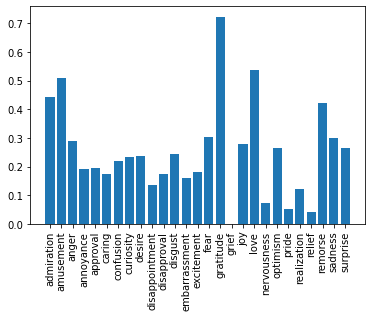

In [24]:
#Using this threshold of 0.2, we can determine the F1 score for each individual emotion:
column_names = list(data.columns[9:])
threshold = 0.2
f1_scores = []
for i in range(0,27):
    emotion_prediction = y_pred[:,i]
    emotion_prediction[emotion_prediction>=threshold]=1
    emotion_prediction[emotion_prediction<threshold]=0
    emotion_test = y_test[:,i]
    precision = precision_score(emotion_test, emotion_prediction)
    recall = recall_score(emotion_test, emotion_prediction)
    f1 = f1_score(emotion_test, emotion_prediction)
    print("Emotion: {}, Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(column_names[i], precision, recall, f1))
    f1_scores.append(f1)
    

import matplotlib.pyplot as plt
fig = plt.figure()
plt.bar(column_names[0:27],f1_scores)
plt.xticks(rotation=90)
plt.show()

In [25]:
pred = y_pred.copy()
pred[pred>=0.2] = 1
pred[pred<0.2] =0
print("Average F1-Score across Multi-Lbales: {}".format(f1_score(y_test, pred, average='micro')))

Average F1-Score across Multi-Lbales: 0.3378517281254016
